<a href="https://colab.research.google.com/github/Mai-Binh-Nam/new_york_city_taxi_fare_prediction-/blob/main/Taxi_Fare_NYC_Mai_Binh_Nam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import** Library and Data

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import random
import folium

import matplotlib.pyplot as plt
import seaborn as sns
# Option to specify the default size of plots by seaborn. A4 size
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "maibinhnam" # username from the json file
os.environ['KAGGLE_KEY'] = "d06fff630bbb1746980e9e00d2b2af75" # key from the json file
!kaggle datasets download -d olistbr/brazilian-ecommerce

 75% 32.0M/42.7M [00:00<00:00, 83.5MB/s]
100% 42.7M/42.7M [00:00<00:00, 123MB/s] 


In [ ]:
!unzip -q train.csv.zip -d.

replace ./train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
!ls

brazilian-ecommerce.zip  sample_data


## Create random sample (size=5000000) from training data set



In [ ]:
df_train=pd.read_csv("train.csv",nrows = 1000000,parse_dates=["pickup_datetime"])

In [ ]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


# **Quesion**

Quá trình vận hành một doanh nghiệp taxi, chúng tôi lo ngại rằng việc tính sai tiền vé cho mỗi chuyến đi sẽ làm ảnh hưởng đến mức độ hài lòng và hình ảnh doanh nghiệp trong khách hàng. Những sai số đó có thể đến từ sự hự hỏng của máy móc hoặc sự gian lận của tài xế. Để phát hiện ra những gian lận như vậy, chúng tôi cần giải thích được sự phụ thuộc của giá tiền vào các yếu tố khách trong chuyến đi.

# **Technique**

# **EDA**

Hypothesis:

*   Quảng đường di chuyển càng dài thì giá vé sẽ cao hơn.
*   Thời gian di chuyển vào giờ cao điểm giá vé sẽ cao hơn.
*   Ngày cuối tuần giá vé sẽ cao hơn.
*   Giá vé năm sau sẽ cao hơn giá vé năm trước đó.
*   Chuyến đi có càng nhiều khách thì giá vé sẽ càng cao.
*   Giá vé sẽ khách nhau tùy theo các quận khách nhau trong thành phố.
*   Đón trả khách tại sân bay giá vé sẽ cao hơn.



Technique: Sử dụng các mô hình Regression (linear, decision tree)

## Remove ourliers and missing values

### Remove missing values

In [ ]:
pd.isnull(df_train).sum(axis=0)

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

Remove all null values

In [ ]:
df_train = df_train.dropna(how = 'any', axis = 'rows')

### Remove ourliers

In [ ]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.347953,-72.526699,39.929040,-72.527860,39.919954,1.684941
std,9.821790,12.057778,7.626087,11.324494,8.201418,1.323907
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


Min of 'fare_amount' is negative. This is nonsense, so I will remove all that.



In [ ]:
len(df_train[df_train["fare_amount"]<=0])

67

In [ ]:
df_train=df_train.drop(df_train[df_train["fare_amount"]<=0].index, axis = 0)

"passenger_count" = 208

In [ ]:
df_train[df_train["passenger_count"]>6]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
929022,2009-07-30 11:54:00.000000193,3.3,2009-07-30 11:54:00+00:00,0.0,0.0,0.0,0.0,208


We see max of 'passenger_count' is 208. This is not true, so we remove it.

In [ ]:
df_train=df_train.drop(df_train[df_train['passenger_count']>6].index, axis = 0)

We see lat and long in NYC:
*   Latitude from 40 to 45
*   Longitude from -80 to -72

In [ ]:
df_train=df_train[(df_train["pickup_longitude"]<=-72.986532) & (df_train["pickup_longitude"]>=-74.263242) & 
                           (df_train["dropoff_longitude"]<=-72.986532) & (df_train["dropoff_longitude"]>=-74.263242) &
                           (df_train["pickup_latitude"]<=41.709555) & (df_train["pickup_latitude"]>=40.573143) &
                           (df_train["dropoff_latitude"]<=41.709555) & (df_train["dropoff_latitude"]>=40.573143)]

In [ ]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,978775.000000,978775.000000,978775.000000,978775.000000,978775.000000,978775.000000
mean,11.321953,-73.975084,40.751133,-73.974180,40.751477,1.685021
std,9.672727,0.038336,0.029476,0.037426,0.032624,1.307718
min,0.010000,-74.262970,40.575871,-74.255750,40.573200,0.000000
25%,6.000000,-73.992266,40.736590,-73.991567,40.735607,1.000000
50%,8.500000,-73.982082,40.753422,-73.980587,40.753880,1.000000
75%,12.500000,-73.968315,40.767583,-73.965322,40.768420,2.000000
max,500.000000,-73.011752,41.696852,-73.011777,41.646975,6.000000


## Calculate distance

In [ ]:
from geopy.distance import geodesic 
def distance(row):
    pickup_location = row['pickup_latitude'], row['pickup_longitude']
    dropoff_location = row['dropoff_latitude'], row['dropoff_longitude']
    return geodesic(pickup_location, dropoff_location).km
df_train['distance_km'] = df_train.apply(distance, axis=1)

Remove 'distance_km' = 0 (means: pickup_point same dropoff_point)

In [ ]:
len(df_train[df_train['distance_km']==0])

10457

In [ ]:
df_train[df_train['distance_km']==0].head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
105,2009-03-25 00:08:52.0000001,52.0,2009-03-25 00:08:52+00:00,-74.035839,40.747320,-74.035839,40.747320,1,0.0
191,2014-01-08 21:55:58.0000006,6.5,2014-01-08 21:55:58+00:00,-73.998488,40.726303,-73.998488,40.726303,1,0.0
270,2012-08-25 01:53:42.0000005,7.5,2012-08-25 01:53:42+00:00,-73.995892,40.746454,-73.995892,40.746454,1,0.0
290,2009-12-14 12:33:00.00000075,6.9,2009-12-14 12:33:00+00:00,-73.982432,40.745747,-73.982432,40.745747,1,0.0
396,2014-03-12 18:12:44.0000006,12.0,2014-03-12 18:12:44+00:00,-73.844904,40.736318,-73.844904,40.736318,1,0.0


In [ ]:
df_train=df_train.drop(df_train[df_train['distance_km']==0].index,axis=0)

## How position affects fare_amount?

### Position is Airport.

(40.63, 40.85)

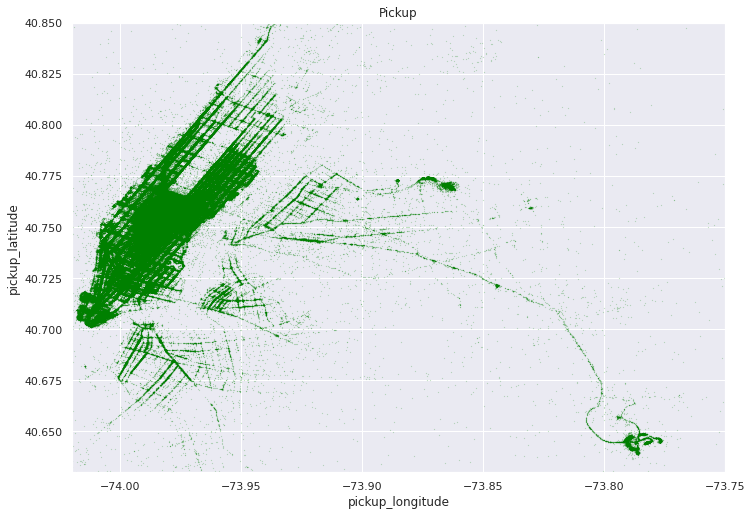

In [ ]:
df_train.plot(kind='scatter',x='pickup_longitude',y='pickup_latitude',color='green',s=.02, alpha=.6)
plt.title("Pickup")

plt.xlim((-74.02, -73.75))
plt.ylim((40.63, 40.85))

(40.63, 40.85)

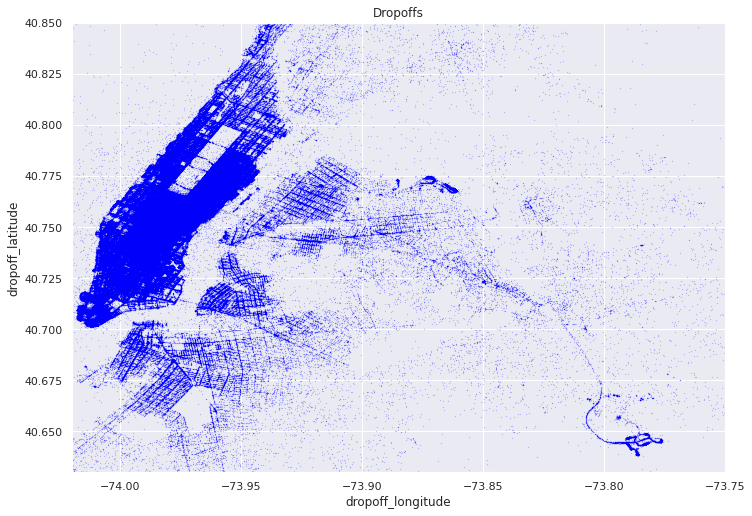

In [ ]:
df_train.plot(kind='scatter',x='dropoff_longitude',y='dropoff_latitude',color='blue',s=.02, alpha=.6)
plt.title("Dropoffs")

plt.xlim((-74.02, -73.75))
plt.ylim((40.63, 40.85))

*As can be seen, the pick up and drop off locations are mostly distributed at the airport* **LaGuardia Airport**(40.7730135746,-73.8702298524) and 	**John F. Kennedy International Airport**(40.641766,-73.780968).

Tạo biến giả phân loại các chuyến đi là bắt đầu từ sân bay hoặc không.

(tham khảo: https://www.kaggle.com/aiswaryaramachandran/eda-and-feature-engineering)

In [ ]:
nyc_airports={'JFK':{'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659},
              
    'EWR':{'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        },
    'LaGuardia':{'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
        
    }
    
}

def isAirport(latitude,longitude,airport_name='JFK'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0

In [ ]:
df_train['is_pickup_JFK']=df_train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
df_train['is_dropoff_JFK']=df_train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)

In [ ]:
df_train['is_pickup_EWR']=df_train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
df_train['is_dropoff_EWR']=df_train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)

In [ ]:
df_train['is_pickup_la_guardia']=df_train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
df_train['is_dropoff_la_guardia']=df_train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)

Với những chuyến đi có địa điểm đón tại sân bay, giá tiền 'fare_amount' chủ yếu là các giá trị lớn hơn.

**JFK AIRPORT**

Text(0.5, 1.0, 'Fare Amount Distribution of JFK verus All trip')

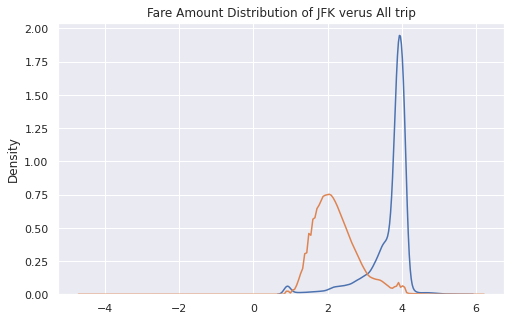

In [ ]:
data_pickup_JFK=df_train[df_train['is_pickup_JFK']==1]
plt.figure(figsize=(8,5))

sns.kdeplot(np.log(data_pickup_JFK['fare_amount'].values),label=' Trip pickup JFK')
sns.kdeplot(np.log(df_train['fare_amount'].values),label='All trip')
plt.title("Fare Amount Distribution of JFK verus All trip")

**EWR AIRPORT**

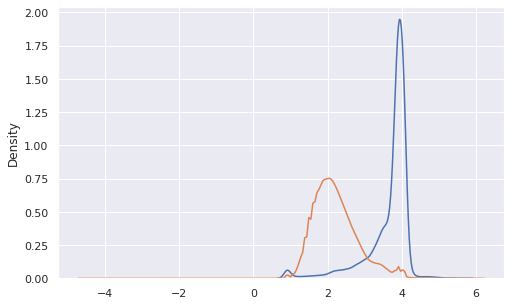

In [ ]:
data_pickup_EWR=df_train[df_train['is_pickup_EWR']==1]
plt.figure(figsize=(8,5))

sns.kdeplot(np.log(data_pickup_JFK['fare_amount'].values),label='Trip pickup EWR')
sns.kdeplot(np.log(df_train['fare_amount'].values),label='All trip')

Với những chuyến đi có địa điểm trả khách tại sân bay, giá tiền 'fare_amount' chủ yếu là các giá trị lớn hơn.

Text(0.5, 1.0, 'Fare Amount Distribution of JFK verus All trip')

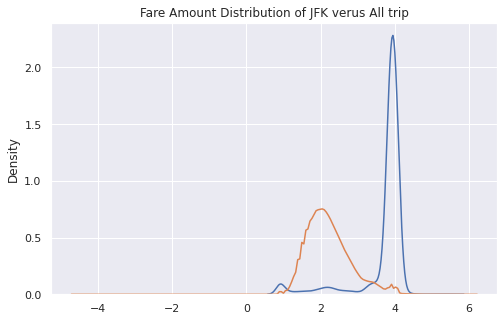

In [ ]:
data_dropoff_JFK=df_train[df_train['is_dropoff_JFK']==1]
plt.figure(figsize=(8,5))

sns.kdeplot(np.log(data_dropoff_JFK['fare_amount'].values),label=' Trip dropoff JFK')
sns.kdeplot(np.log(df_train['fare_amount'].values),label='All trip')
plt.title("Fare Amount Distribution of JFK verus All trip")

*Có thể thầy rằng, các chuyến đi có pickup hoặc dropoff tại sân bay 'fare_amount' lớn có mần độ cao. Việc đón trả khách tại sân bay đã ảnh hưởng tới giá tiền của chuyến đi. Nó làm giá tiền cao liên so với mức bình thường*

## How datetime pickup affect fare_mount?

Handling datatime

In [ ]:
df_train['year']=pd.to_datetime(df_train['pickup_datetime']).dt.year
df_train['month']=pd.to_datetime(df_train['pickup_datetime']).dt.month
df_train['day']=pd.to_datetime(df_train['pickup_datetime']).dt.day
df_train['day_of_week']=pd.to_datetime(df_train['pickup_datetime']).dt.dayofweek
df_train['hour']=pd.to_datetime(df_train['pickup_datetime']).dt.hour

Giá vé có thể tăng qua từng năm.

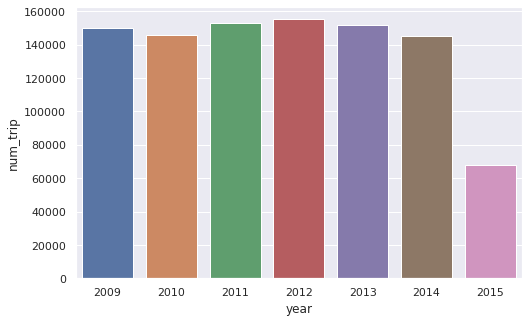

In [ ]:
df_year=df_train.groupby('year').agg({'key':'nunique',
                                    'fare_amount':'mean'})\
                                    .reset_index()\
                                    .rename(columns={'key':'num_trip','fare_amount':'avg_fare_amount'})
plt.figure(figsize=(8,5))
sns.barplot(x='year',y='num_trip',data=df_year)

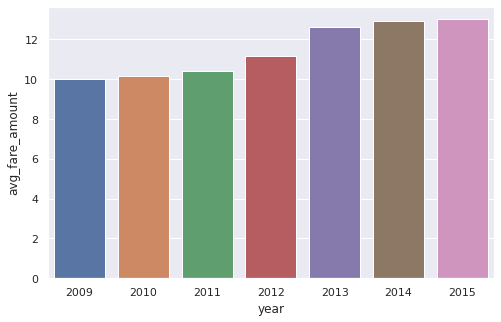

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='year',y='avg_fare_amount',data=df_year)

Các giờ cao điểm, xe lưu thông chậm hơn so với bình thường. Những giờ này có thể giá vé cao hơn, nên cần xem ảnh hưởng của các khung giờ trong ngày đối với giá vé.

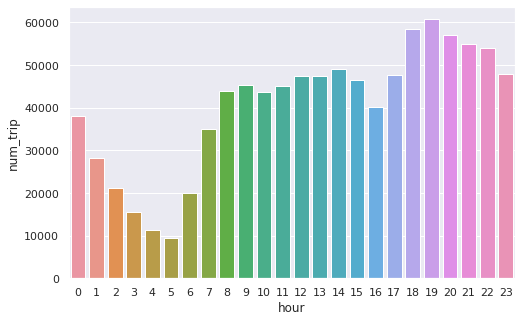

In [ ]:
df_hour=df_train.groupby('hour').agg({'key':'nunique',
                                    'fare_amount':'mean'})\
                                    .reset_index()\
                                    .rename(columns={'key':'num_trip','fare_amount':'avg_fare_amount'})
plt.figure(figsize=(8,5))
sns.barplot(x='hour',y='num_trip',data=df_hour)                                    

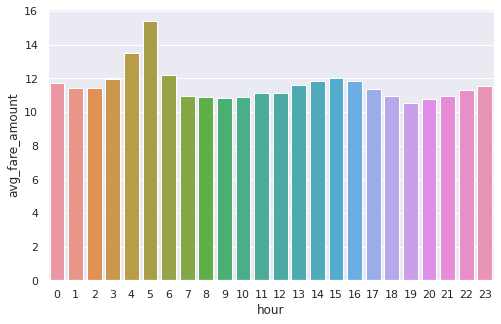

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='hour',y='avg_fare_amount',data=df_hour) 

Cac thứ trong tuần cũng có thể ảnh hưởng đến fare amount.

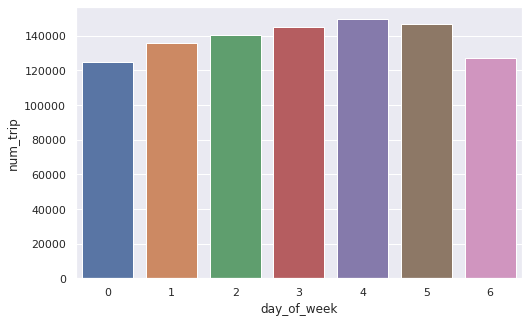

In [ ]:
df_day_of_week=df_train.groupby('day_of_week').agg({'key':'nunique',
                                    'fare_amount':'mean'})\
                                    .reset_index()\
                                    .rename(columns={'key':'num_trip','fare_amount':'avg_fare_amount'})
plt.figure(figsize=(8,5))
sns.barplot(x='day_of_week',y='num_trip',data=df_day_of_week)   

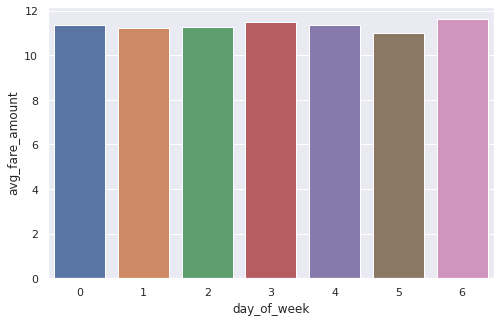

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='day_of_week',y='avg_fare_amount',data=df_day_of_week)

## How number of passengers affect fare_mount?

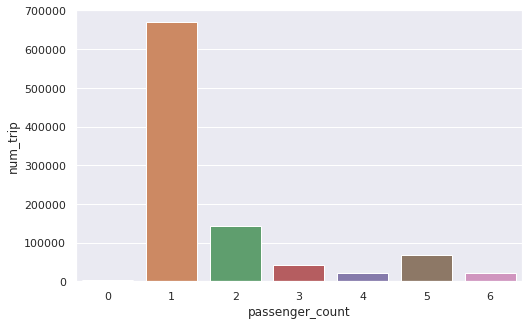

In [ ]:
df_passenger_count=df_train.groupby('passenger_count').agg({'key':'nunique',
                                                            'fare_amount':'mean'})\
                                                            .reset_index()\
                                                            .rename(columns={'key':'num_trip',
                                                                             'fare_amount':'avg_fare_amount'})
plt.figure(figsize=(8,5))
sns.barplot(x='passenger_count',y='num_trip',data=df_passenger_count)                                                          

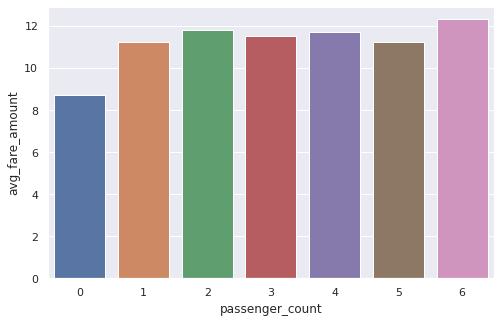

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='passenger_count',y='avg_fare_amount',data=df_passenger_count)    

# Using sklearn Model

In [ ]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_la_guardia,is_dropoff_la_guardia,year,month,day,day_of_week,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.029601,0,0,0,0,0,0,2009,6,15,0,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.443441,0,0,0,0,0,0,2010,1,5,1,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132,0,0,0,0,0,0,2011,8,18,3,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.795790,0,0,0,0,0,0,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.998338,0,0,0,0,0,0,2010,3,9,1,7


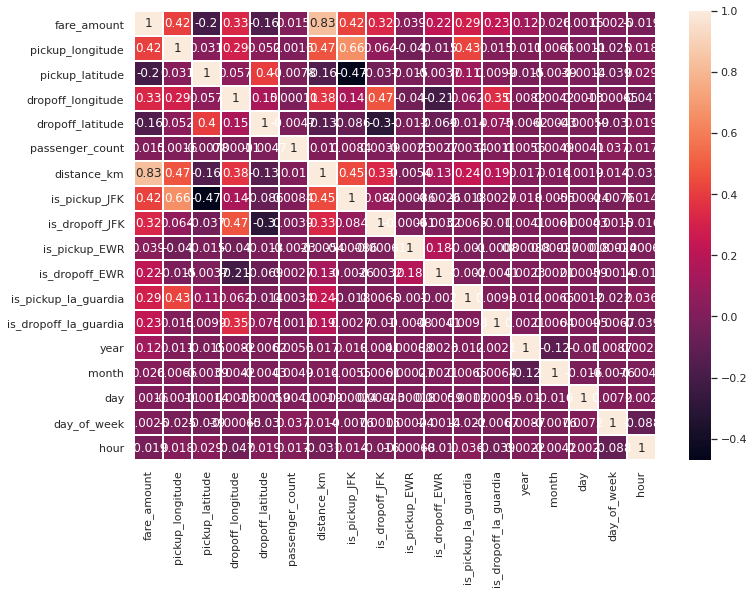

In [ ]:
sns.heatmap(df_train.corr(), linewidth=1, annot=True)

In [ ]:
df_train=df_train.drop('key',axis=1)
df_train=df_train.drop('pickup_datetime',axis=1)
df_train=df_train.drop('pickup_longitude',axis=1)
df_train=df_train.drop('pickup_latitude',axis=1)
df_train=df_train.drop('dropoff_longitude',axis=1)
df_train=df_train.drop('dropoff_latitude',axis=1)
df_train=df_train.drop('passenger_count',axis=1)
df_train=df_train.drop('month',axis=1)
df_train=df_train.drop('day',axis=1)

## Using Statistical Model

In [ ]:
#Indicate variable predict(x) and forecast(y)
y_train = df_train[['fare_amount']]
x_train = df_train[['distance_km','is_pickup_JFK','is_dropoff_JFK','is_pickup_la_guardia','is_dropoff_la_guardia','hour']]

#y_test = test_set[['fare_amount']]
#x_test=test_set.drop('fare_amount',axis=1)

In [ ]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

X2 = sm.add_constant(x_train)
# X2 = X
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                 4.074e+05
Date:                Sat, 14 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:47:59   Log-Likelihood:            -2.9544e+06
No. Observations:              968318   AIC:                         5.909e+06
Df Residuals:                  968311   BIC:                         5.909e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.67

In [ ]:
ypred = est2.predict(df_train[['distance_km','is_pickup_JFK','is_dropoff_JFK','is_pickup_la_guardia','is_dropoff_la_guardia','hour','fare_amount']])

In [ ]:
df_train['pred']=ypred
df_train[['fare_amount','pred']]

,fare_amount,pred
0,4.5,140.928677
1,16.9,167.614458
2,5.7,6.511173
3,7.7,45.116190
4,5.3,65.399157
...,...,...
999994,20.0,214.737125
999995,7.0,176.943645
999997,10.5,120.357672
999998,6.9,8.624471


In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif["features"] = X2.columns
vif

,VIF Factor,features
0,6.486113,const
1,1.629959,distance_km
2,1.304991,is_pickup_JFK
3,1.151062,is_dropoff_JFK
4,1.101354,is_pickup_la_guardia
5,1.059562,is_dropoff_la_guardia
6,1.005206,hour


## LinearRegression Model

In [ ]:
# divide data set into trainning set and testìng set
from sklearn.model_selection import train_test_split
train_set, test_set= train_test_split(df_train,train_size=0.90)

In [ ]:
y_train = train_set[['fare_amount']]
x_train = train_set[['distance_km','is_pickup_JFK','is_dropoff_JFK','is_pickup_la_guardia','is_dropoff_la_guardia','hour']]

y_test = test_set[['fare_amount']]
x_test=test_set[['distance_km','is_pickup_JFK','is_dropoff_JFK','is_pickup_la_guardia','is_dropoff_la_guardia','hour']]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import linear_model
slr = LinearRegression()
lm=slr.fit(x_train, y_train)

y_train_pred = lm.predict(x_train)
y_test_pred = lm.predict(x_test)

In [ ]:
print("Coefficients: ", lm.coef_[0])
print("Intercept: ", lm.intercept_)

Coefficients:  [1.83147954e+00 7.45992927e+00 8.37971260e+00 7.83617408e+00
 8.01694113e+00 3.20364690e-03]
Intercept:  [4.68144812]


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_train_err = mean_squared_error(y_train, y_train_pred)
print('Mean Sqaured Error for Training data is : ',(y_train_err))

y_test_err = mean_squared_error(y_test, y_test_pred)
print('Mean Sqaured Error for Testing data is : ',(y_test_err))

Mean Sqaured Error for Training data is :  26.01212723055756
Mean Sqaured Error for Testing data is :  27.497003030121416


In [ ]:
test_set['pred']=y_test_pred
test_set[['fare_amount','pred']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,fare_amount,pred
743911,4.90,5.760674
337901,4.90,6.814808
983912,10.10,12.262936
836542,22.50,23.043983
684975,5.70,6.814637
...,...,...
996995,3.50,5.374657
520051,24.50,17.730722
720033,5.70,7.343920
723915,36.33,28.387500


## Random Forest Model

In [ ]:
df_train=df_train.drop('pred',axis=1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)

In [ ]:
y_test['prediction']=y_test_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
y_test['residual']=abs(y_test['prediction']-y_test['fare_amount'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
y_test.describe()

In [ ]:
y_test

,fare_amount,prediction,residual
743911,4.90,4.9610,0.0610
337901,4.90,5.1560,0.2560
983912,10.10,12.3170,2.2170
836542,22.50,24.7180,2.2180
684975,5.70,6.0950,0.3950
...,...,...,...
996995,3.50,3.5190,0.0190
520051,24.50,17.9580,6.5420
720033,5.70,8.8580,3.1580
723915,36.33,34.3272,2.0028


In [ ]:
y_train_err = mean_squared_error(y_train['fare_amount'], y_train_pred)

print('Mean Sqaured Error for Training data is : ',(y_train_err))

y_test_err = mean_squared_error(y_test['fare_amount'], y_test_pred)

print('Mean Sqaured Error for Training data is : ',(y_test_err))

Mean Sqaured Error for Training data is :  3.4234608753987685
Mean Sqaured Error for Training data is :  25.198518293037022
